a compositional structure with AB and ABCD (two chunks with the same beginning)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
sys.path.append(os.getcwd())
from RNN_util import *
import numpy as np

# Generate sequence with words that contain context-dependent subparts

In [2]:
# Data preparation
vocab = ['CDAB','AB', 'ABCD', 'E']
probabilities = [0.10,0.10,0.10, 0.7]
nit = 10000
sequence = ''
for _ in range(0, nit):
    # sample one of the words
    # followed by at least one 'E'
    sequence = ''.join([sequence,np.random.choice(vocab, p=probabilities)])
    sequence = ''.join([sequence,'E'])

In [3]:
# Create a dictionary to convert characters to integers
char_to_int = {char: i for i, char in enumerate('ABCDE')}
# Create a dictionary to convert integers to characters
int_to_char = {i: char for i, char in enumerate('ABCDE')}

In [4]:
# the same RNN Model as usual
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # update hidden 
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined) # nn.Linear(input_size + hidden_size, hidden_size)
        output = self.i2o(combined) # nn.Linear(input_size + hidden_size, output_size)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        

In [5]:
# Model parameters
hidden_size = 12
input_size = len(char_to_int)
output_size = len(char_to_int)

rnn = RNN(input_size, hidden_size, output_size) 
rnn, hidden_states, hidden_seq,_,_,_ = train_rnn(rnn, sequence,input_size,char_to_int, int_to_char, n_iters = 500)

Iteration 100 loss: 0.7222993469238281 acc: 0.775
Iteration 200 loss: 0.5110803985595703 acc: 0.87
Iteration 300 loss: 0.4815890884399414 acc: 0.84
Iteration 400 loss: 0.43742679595947265 acc: 0.86
Iteration 500 loss: 0.4155623626708984 acc: 0.88


In [6]:
hidden = rnn.initHidden()
input_char = 'A'
for i in range(6):
    input_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[input_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
    output, hidden = rnn(input_tensor, hidden)
    predict_char = int_to_char[output.argmax(1).item()]
    print('previous char ', input_char,' prediction char ', int_to_char[output.argmax(1).item()])
    input_char = predict_char

previous char  A  prediction char  B
previous char  B  prediction char  E
previous char  E  prediction char  E
previous char  E  prediction char  E
previous char  E  prediction char  E
previous char  E  prediction char  E


In [7]:
hidden_states = np.array(hidden_states)
hidden_unit_activity = hidden_states[:, 0, :].T
cluster_center_record, symbolic_hidden_activity = learn_neural_clusters(hidden_unit_activity)
symbolic_hidden_activity = np.array(symbolic_hidden_activity) # each label in each neuron is independent

# compare trained, versus untrained neural network, and their internal state statistics

In [ ]:
hidden_size = 12
input_size = len(char_to_int)
output_size = len(char_to_int)

input_parse_educated = []
input_parse_uneducated = []
n_state_educated = []
n_state_uneducated = []
vocab_size_educated = []
vocab_size_uneducated = []
parsed_vocab_size_educated = [] # vocab size at the last parse 
parsed_vocab_size_uneducated = [] # vocab size at the last parse
filtered_vocab_size_educated = []
filtered_vocab_size_uneducated = []

n_iter = 10
for i in range(0,n_iter): 
    # uneducated version
    uneducated_rnn = RNN(input_size, hidden_size, output_size) 

    uneducated_NN, uneducated_hidden_states, uneducated_hidden_seq,_,_,_ = train_rnn(uneducated_rnn, sequence, input_size, char_to_int, int_to_char, n_iters = 200, chunk_len = 2000, learn = False)
    # uneducated_NN, uneducated_hidden_states, uneducated_hidden_seq  = train_rnn(uneducated_rnn, sequence, n_iters = 200,chunk_len = 2000, learn = False)
    uneducated_hidden_states = np.array(uneducated_hidden_states)
    uneducated_hidden_unit_activity = uneducated_hidden_states[:, 0, :].T
    uneducated_cluster_center_record, uneducated_symbolic_hidden_activity = learn_neural_clusters(uneducated_hidden_unit_activity)
    uneducated_symbolic_hidden_activity = np.array(uneducated_symbolic_hidden_activity) # each label in each neuron is independent
    uneducated_trajcopy, uneducated_input_parse,uneducated_vocab, initial_uneducated_vocab = learn_chunks(uneducated_symbolic_hidden_activity,uneducated_hidden_seq)
    
    # educated version
    educated_rnn = RNN(input_size, hidden_size, output_size) 
    educated_NN, educated_hidden_states, educated_hidden_seq,_,_,_ = train_rnn(educated_rnn, sequence, input_size, char_to_int, int_to_char, n_iters = 200, chunk_len = 2000, learn = True)
    # educated_NN, educated_hidden_states, educated_hidden_seq  = train_rnn(educated_rnn, sequence, n_iters = 200, chunk_len = 2000, learn = True)
    educated_hidden_states = np.array(educated_hidden_states)
    educated_hidden_unit_activity = educated_hidden_states[:, 0, :].T
    educated_cluster_center_record, educated_symbolic_hidden_activity = learn_neural_clusters(educated_hidden_unit_activity)
    educated_symbolic_hidden_activity = np.array(educated_symbolic_hidden_activity) # each label in each neuron is independent
    educated_trajcopy, educated_input_parse,educated_vocab,initial_educated_vocab = learn_chunks(educated_symbolic_hidden_activity,educated_hidden_seq)
    
    input_parse_educated.append(len(educated_trajcopy))
    input_parse_uneducated.append(len(uneducated_trajcopy))
    
    n_state_educated.append(len(initial_educated_vocab))
    n_state_uneducated.append(len(initial_uneducated_vocab))

    vocab_size_educated.append(len(educated_vocab))
    vocab_size_uneducated.append(len(uneducated_vocab))
    
    parsed_vocab_size_educated.append(len(Counter(educated_trajcopy)))
    parsed_vocab_size_uneducated.append(len(Counter(uneducated_trajcopy)))
    
    filtered_vocab_ed = {key: value for key, value in educated_vocab.items() if value > 5}
    filtered_vocab_un = {key: value for key, value in uneducated_vocab.items() if value > 5}
    filtered_vocab_size_educated.append(len(filtered_vocab_ed))
    filtered_vocab_size_uneducated.append(len(filtered_vocab_un))

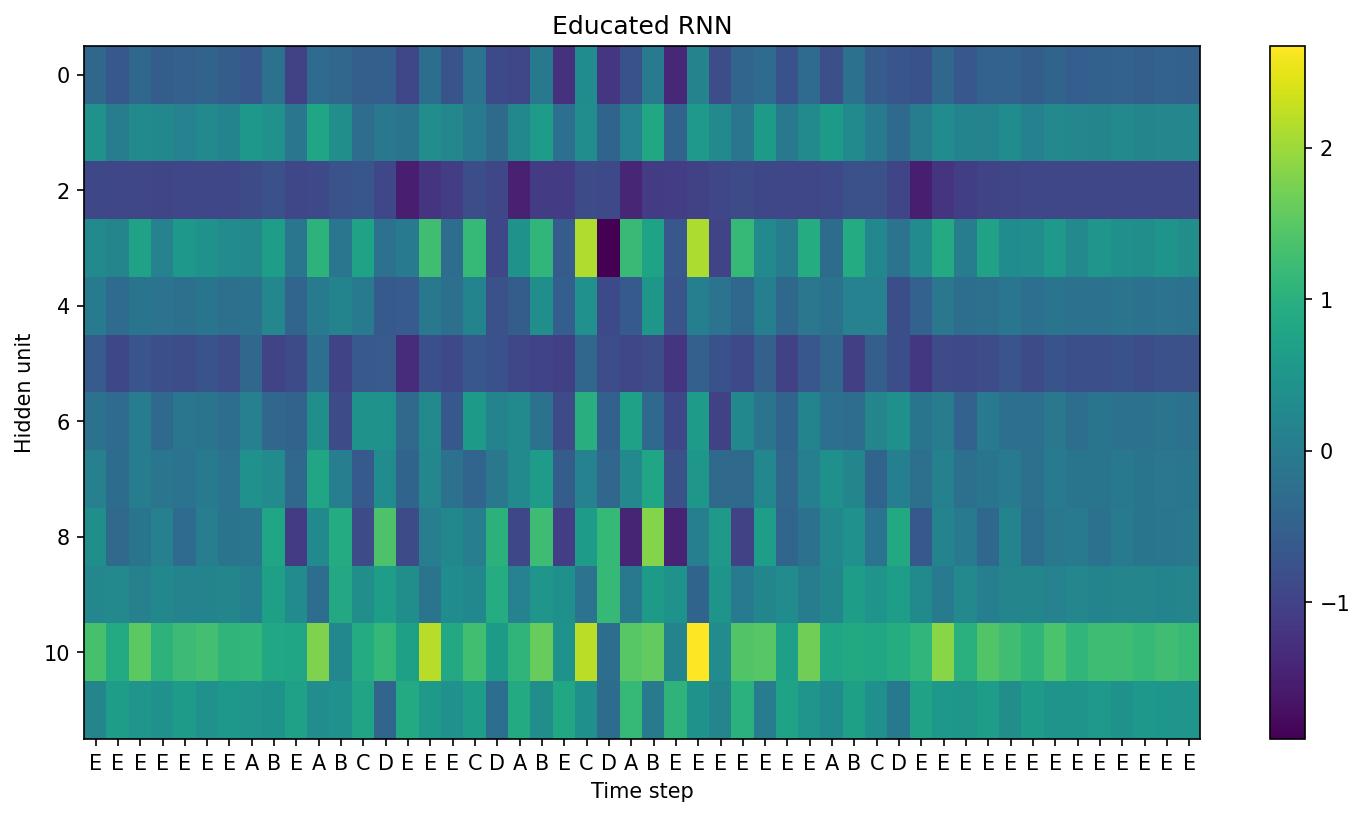

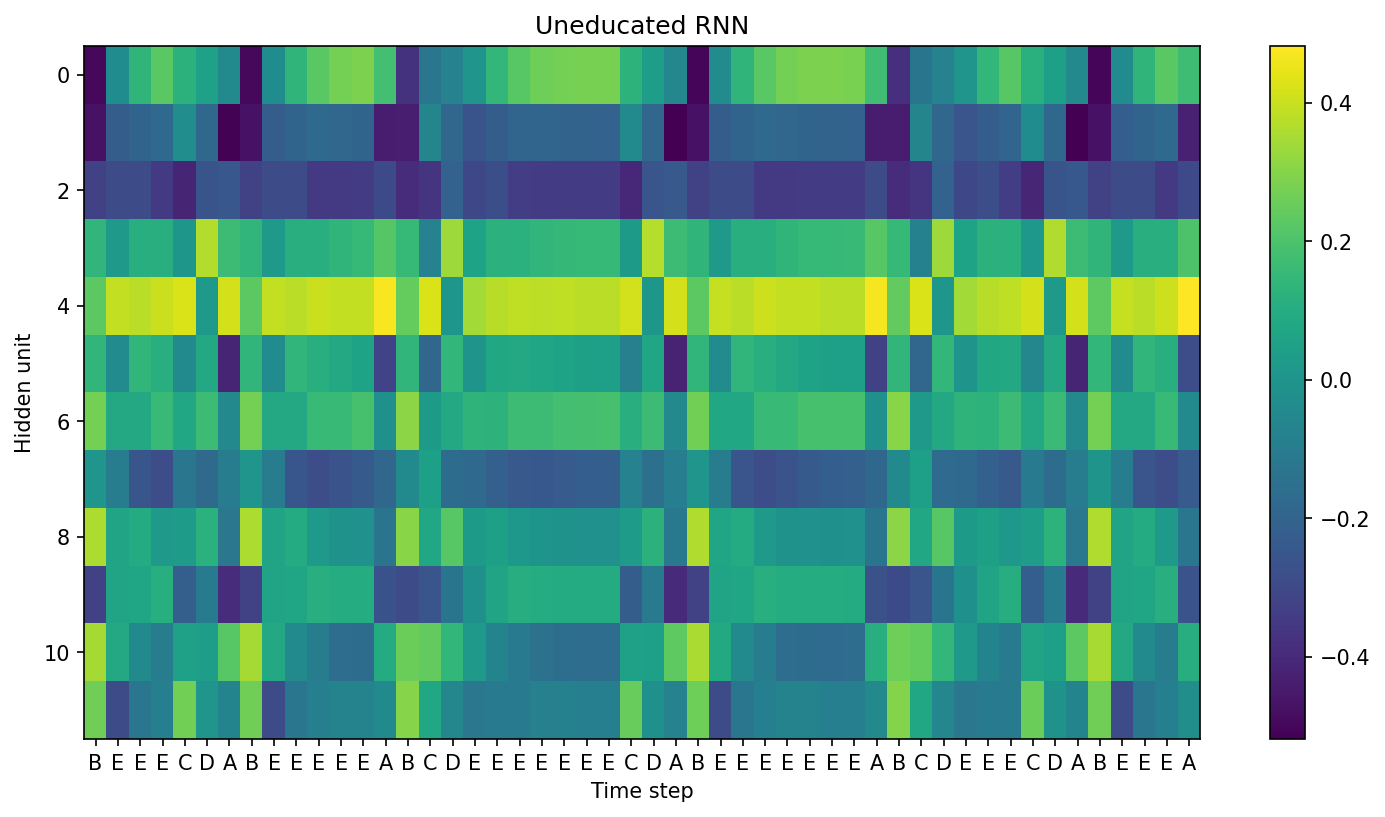

In [14]:
# optionally, visualize the educated and uneducated hidden states 
L = 50
R = 100
hidden_states = np.array(educated_hidden_states)
hidden_unit_activity = hidden_states[:, 0, :].T

plt.figure(figsize=(12, 6), dpi = 150)
plt.imshow(hidden_unit_activity[:,L:R], aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('Time step')
plt.ylabel('Hidden unit')
plt.xticks(range(0, len(educated_hidden_seq[L:R])),list(educated_hidden_seq[L:R]))
plt.title('Educated RNN')
plt.show()

hidden_states = np.array(uneducated_hidden_states)
hidden_unit_activity = hidden_states[:, 0, :].T
plt.figure(figsize=(12, 6), dpi = 150)
plt.imshow(hidden_unit_activity[:,L:R], aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('Time step')
plt.ylabel('Hidden unit')
plt.xticks(range(0, len(uneducated_hidden_seq[L:R])),list(uneducated_hidden_seq[L:R]))
plt.title('Uneducated RNN')
plt.show()


In [15]:
import json
# Example dictionary
data = {
    'input_parse_uneducated': input_parse_uneducated,
    'input_parse_educated': input_parse_educated,
    'n_state_educated' :n_state_educated,
    'n_state_uneducated':n_state_uneducated,
    'vocab_size_educated':vocab_size_educated,
    'vocab_size_uneducated': vocab_size_uneducated,
    'parsed_vocab_size_educated':parsed_vocab_size_educated,
    'parsed_vocab_size_uneducated': parsed_vocab_size_uneducated,
    'filtered_vocab_size_educated':filtered_vocab_size_educated,
    'filtered_vocab_size_uneducated': filtered_vocab_size_uneducated,
}
# Save the dictionary as a JSON file
with open('comparison_on_educated_vs_uneducated_network.json', 'w') as json_file:
    json.dump(data, json_file)

print('Dictionary saved to data.json')


Dictionary saved to data.json


## make some bar plots to show the parsing length of some sequences 

In [19]:
# get original sequence length 
original_seq = ''
for item in educated_input_parse:
    original_seq = original_seq+''.join(list(item))
print(original_seq)
original_seql = 0
i = 0
while i <=len(original_seq):
    if original_seq[i:i+4] == 'ABCD' or original_seq[i:i+4] == 'CDAB':
        original_seql  = original_seql + 1
        i = i + 4
    elif original_seq[i:i+2] == 'AB':
        original_seql = original_seql + 1
        i = i +2
    else:
        original_seql = original_seql + 1
        i = i + 1
        
print(original_seql)

EABCDEEEEEEEEEEEEECDABEEEABECDABEEEABEEEEECDABEEEEEEEEEEEABEABCDEEECDABECDABEEEEEEEABCDEEEEEEEEEEEEEABCDEEEEEABEEEEEEEEEEEEEEEEEABEABCDEEEEEEEABEEEEEEEEEEEEEABCDEEEEEEEABCDEEECDABEABEABEEEEEEEEEEEABEEEABEEEEEABEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEABEEEEEABCDEEEEEEEEEEEABCDEEEEEEEEECDABEEEEEEEEEABCDEEEEEEEEEEEEEEEEEEEABCDEABCDEEEEEABEEEABECDABEABEEEEEEEEEEEEEABCDECDABEEEEEEEEEEEEEEEEEEEEEABEEEEEEEEEEEABCDEEEEEEEEEEEEEEEEEEEABCDEEEEEEEEEABEEEEEEEEEABCDEEEEEEEEEABCDEABEEEEEEEEEEEEEEEEEEEEEABCDEABCDEEEABEEEEEEEEEEEABEABEEEEEABCDEABEEEEECDABEEEEEABEABEEEEEEEABCDEEEEEEEEEEEEEEEEEEEEEEEEEABEEEEECDABEABCDEABCDEABEEEEEEEEEEEEECDABEEEEEABEEEEECDABEEEEEEEEEEECDABEEEEEEEEEEEABEEEABCDEEEEEEEEECDABEEEABEEEEEEEEECDABEEEABCDEEECDABEEEEEEEEEEEEEEEEEEEABEEECDABEEEEEEEEEABCDEABECDABEEEEEEEEEABEABEEEEEABEEEEEEEABCDEEEABCDECDABEABEABEABCDEEEEEEEEEABCDEEEEEEEEECDABEEEEEABECDABEEEABEEEEEEEEECDABEABCDEEEEEABECDABEABEEEABCDEEEEEEEEEEEEEEEEEABCDEEEEECDABECDABEEEEEEEEEEEEEEECDABEEEABEEECDABEABEABCDEEEABEEEEEABCDEABCDE

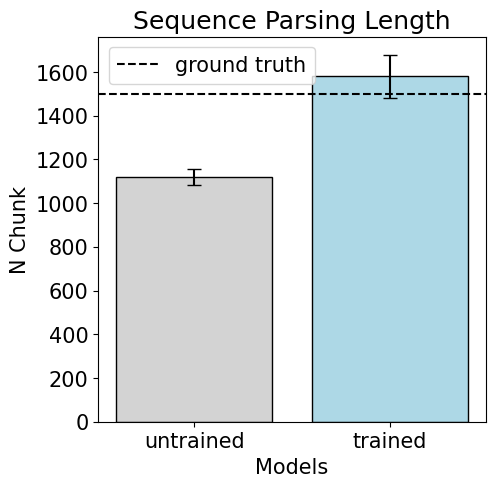

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import json
load = True


# compare with sequence parse ground truth 

if load:
    # Load the dictionary from a JSON file
    with open('comparison_on_educated_vs_uneducated_network.json', 'r') as json_file:
        loaded_data = json.load(json_file)
    input_parse_uneducated = loaded_data['input_parse_uneducated']
    input_parse_educated = loaded_data['input_parse_educated']
    
    n_state_educated = loaded_data['n_state_educated']
    n_state_uneducated = loaded_data['n_state_uneducated']
    
    vocab_size_educated = loaded_data['vocab_size_educated']
    vocab_size_uneducated = loaded_data['vocab_size_uneducated']
    
    parsed_vocab_size_educated = loaded_data['parsed_vocab_size_educated']
    parsed_vocab_size_uneducated = loaded_data['parsed_vocab_size_uneducated']
    
    
    filtered_vocab_size_educated = loaded_data['filtered_vocab_size_educated']
    filtered_vocab_size_uneducated = loaded_data['filtered_vocab_size_uneducated']

# Calculate the means
mean_une = np.mean(input_parse_uneducated)
mean_educated = np.mean(input_parse_educated)

# Calculate the standard errors
se1 = stats.sem(input_parse_uneducated)
se2 = stats.sem(input_parse_educated)

means = [mean_une, mean_educated]
standard_errors = [se1, se2]
labels = ['untrained', 'trained']
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(5,5), dpi = 100)
plt.bar(labels, means, yerr=standard_errors, capsize=5, color=['lightgray', 'lightblue'], edgecolor='black')
plt.axhline(y=original_seql, color='black', linestyle='--', linewidth=1.5, label = 'ground truth')
plt.xlabel('Models')
plt.ylabel('N Chunk')
plt.title('Sequence Parsing Length')
plt.legend(loc = 'best')
plt.show()

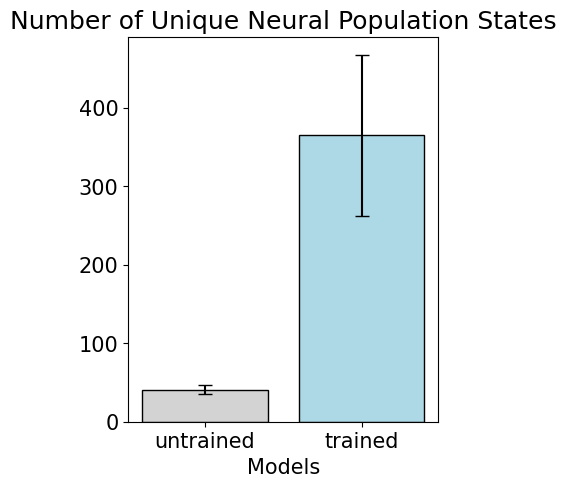

In [21]:
mean_une = np.mean(n_state_uneducated)
mean_educated = np.mean(n_state_educated)

se1 = stats.sem(n_state_uneducated)
se2 = stats.sem(n_state_educated)

means = [mean_une, mean_educated]
standard_errors = [se1, se2]
labels = ['untrained', 'trained']
plt.figure(figsize=(4,5), dpi = 100)
plt.bar(labels, means, yerr=standard_errors, capsize=5, color=['lightgray', 'lightblue'], edgecolor='black')
plt.xlabel('Models')
plt.title('Number of Unique Neural Population States') # unique state described by the clustering method
plt.show()    

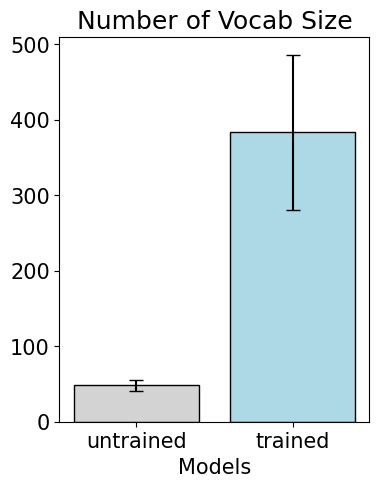

In [22]:
mean_une = np.mean(vocab_size_uneducated)
mean_educated = np.mean(vocab_size_educated)

se1 = stats.sem(vocab_size_uneducated)
se2 = stats.sem(vocab_size_educated)

means = [mean_une, mean_educated]
standard_errors = [se1, se2]
labels = ['untrained', 'trained']
plt.figure(figsize=(4,5), dpi = 100)
plt.bar(labels, means, yerr=standard_errors, capsize=5, color=['lightgray', 'lightblue'], edgecolor='black')
plt.xlabel('Models')
plt.title('Number of Vocab Size')
plt.show()    

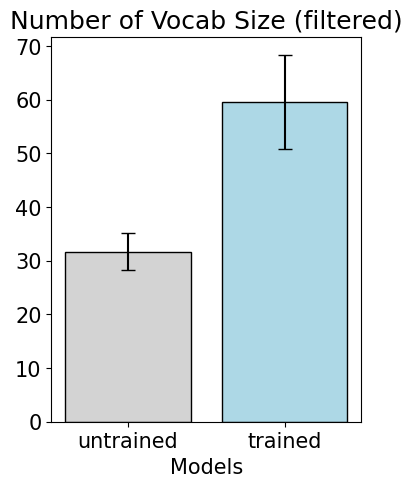

In [23]:
mean_une = np.mean(filtered_vocab_size_uneducated)
mean_educated = np.mean(filtered_vocab_size_educated)

se1 = stats.sem(filtered_vocab_size_uneducated)
se2 = stats.sem(filtered_vocab_size_educated)

means = [mean_une, mean_educated]
standard_errors = [se1, se2]
labels = ['untrained', 'trained']

plt.figure(figsize=(4,5), dpi = 100)
plt.bar(labels, means, yerr=standard_errors, capsize=5, color=['lightgray', 'lightblue'], edgecolor='black')
plt.xlabel('Models')
plt.title('Number of Vocab Size (filtered)')
plt.show()